### Codes for gas dispersion

### model ground concentration given a flux from a volcanic vent and specific atmospheric conditions

Using the approach of Beychok, 1994, Fundamentals of Stack Gas Dispersion (3rd Edition), isbn 0-9644588-2, 193 pp., which is essentially a summary of the EPA approach to calculating gas concentrations downwind from smokestakes

Analytical solution for ground concentration:

$$C(x) = \frac{Q}{u \sigma_y(x) \sigma_z(x) \pi} e^{-\frac{y^2}{2 \sigma_y(x)^2}} e^{-\frac{H_c(x)^2}{2 \sigma_z(x)^2}}$$

and for ground concentration directly beneath the centerline of the plume (which is the maximum ground concentration):

$$C(x) = \frac{Q}{u \sigma_y(x) \sigma_z(x) \pi} e^{-\frac{H_c(x)^2}{2 \sigma_z(x)^2}}$$

where:

$C$ is the concentration (usually expressed in microgram/liter,  $\mu$g /m^3)

$x$ is distance downwind (m), where concentration is measured, m

$Q$ is the emission rate of a gas species (e.g., SO$_2$), in $\mu$g/s.

$u$ is the near-surface wind velocity, usually measured at 10 m above the surface (m/s$^2$)

$\sigma_y$ is the dispersion in the horizontal direction a given distance, $x$ downwind (m)

$\sigma_z$ is the dispersion in the vertical direction a given distance, $x$ downwind (m)

$H_c$ is the height of the plume centerline, a given distance, $x$ downwind from the source (m)

### Complicating factors


#### How is $Q$ determined?

There are different approaches to specifying $Q$. It might be estimated from direct measurements (SO_$2$ flux) or it might be estimated based on the physical flux and the proportion of a given species. This latter approach is useful because these data are needed to calculate the rise rate of the plume

For example:

$$Q \textrm{ kg-mol/s} = Q_g (\textrm{ Nm}^3\textrm{/s}) \times  22.41 (\textrm{ Nm}^3\textrm{kg-mol}) \times \textrm{ 1 hr/ 3600 s}$$

where $Q_g$ is the total gas flow (+ steam) form the volcano. Then:

$$Q \textrm{ (}\mu\textrm{g/m)^3} = Q \textrm{ kg-mol/s} \times  C_{SO_2} \textrm{ ppm in gas} \times 10^{-6} \times 64 \textrm{ kg/mol} \times 10^{9}$$

#### How is the height of the plume centerline calculated?

The exit velocity of gas from the vent (the upward velocity of the buoyant plume) is:

$$ v_s (\textrm{ m/s}) = Q_g (\textrm{ Nm}^3\textrm{/s}) \frac{T_g \textrm{ (K)}}{T_a \textrm{ (K)}} \frac{1}{\pi r_v^2} $$

where $T_g$ is the gas temperature, $T_a$ is the ambient temperature, and $r$ is the vent radius (m)

The atmospheric stability parameter (s$^{-2}$) is:

$$s = \frac{g}{T_a} | \frac{d \theta}{dz}|$$

where: $g$ is gravity and $\frac{d \theta}{dz}$ is the potential temperature gradient in the atmosphere

The buoyancy parameter (m$^4$/s$^3$) is:

$$F = g v_s r^2 \frac{(T_g - T_a)}{T_s} $$

then with $v_s$, $s$ and $F$, use Brigg's equations to calculate height of the plume centerline as a function of distance.

### calculate dispersion

Use Turner's equations and coefficients to estimate $\sigma_y$ and $\sigma_z$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define functions used to calculate the concentration of a gas 
# on the ground, given emission from a volcanic vent
# these are based on EPA stack gas dipersion models summarized in the manual:
# see: Beychok, M.R., 1994, Fundamentals of Stack Gas Dispersion (3rd Edition), isbn 0-9644588-2, 193 pp.

def calc_sigma(pasquill_class, coeff):

    # this look up table is for coefficients in McMullen's
    # implementation of Turner's equation
    CLASS_BREAKPOINTS = ['A', 'B', 'C', 'D', 'E', 'F']
    COEFFICIENT_BREAKPOINTS = ['I', 'J', 'K']

    sigma_z = [
        [6.035, 2.1097, 0.2270],
        [4.694, 1.0629, 0.0136],
        [4.110, 0.9201, -0.0020],
        [3.414, 0.7371, -0.0316],
        [3.057, 0.6794, -0.0450],
        [2.621, 0.6564, -0.0540]]
    
    sigma_y = [
        [5.357, 0.8828, -0.0076],
        [5.058, 0.9024, -0.0096],
        [4.651, 0.9181, -0.0076],
        [4.230, 0.9222, -0.0087],
        [3.922, 0.9222, -0.0064],
        [3.533, 0.9191, -0.0070]]

    row = CLASS_BREAKPOINTS.index(pasquill_class)
    col = COEFFICIENT_BREAKPOINTS.index(coeff)

    return sigma_z[row][col], sigma_y[row][col]


def Turner_dispersion_equation(pasquill_class, x):
    # x is distance downwind in kilometers
    # return Turner's dispersion coefficient in vertical (z)
    # and horizontal (y)
    Iz = calc_sigma(pasquill_class, 'I')[0]
    Jz = calc_sigma(pasquill_class, 'J')[0]
    Kz = calc_sigma(pasquill_class, 'K')[0]
    
    sigma_z = np.exp(Iz + Jz * np.log(x) + Kz * (np.log(x)**2))
    
    Iy = calc_sigma(pasquill_class, 'I')[1]
    Jy = calc_sigma(pasquill_class, 'J')[1]
    Ky = calc_sigma(pasquill_class, 'K')[1]
    
    sigma_y = np.exp(Iy + Jy * np.log(x) + Ky * (np.log(x)**2))
    return sigma_z, sigma_y


def ground_conc(x,y,u,q,ht,stability_class):
    # x is the downwind location of the receptor (m)
    # y is the crosswind location of the receptor (m)
    #   for example, y = 0 is a centerline calculation
    
    # u is the wind velocity in meters per second
    # q is the emission rate of the gas at the source (microgram/m3)
    # ht is the height of the plume centerline (m) above the terrain at the location x
    # stability_class is the atmospheric Pasquill stability class (A-F)
    
    distance_km = x/1000 # diffusion is based on kilometers from the source
    sigma_z, sigma_y = Turner_dispersion_equation(stability_class, distance_km)
    
    concentration = q/(u*sigma_z*sigma_y*np.pi) * np.exp(-y**2/2*sigma_y**2) * np.exp(-ht**2/(2*sigma_z**2))
    return concentration #microgram/m3
    
    
def vent_exit_velocity(q, gas_temperature, vent_diameter):
    # q is the total gas flux in Nm3/s
    # gas_temperature is the gas temperature at the vent (C) (converted to K inside this function)
    # vent_diameter is the diameter of the vent in m
    
    gas_exit_velocity = q * ((gas_temperature + 273)/273) / (np.pi * (vent_diameter/2)**2)
    return gas_exit_velocity #m/s
    
def atm_stability_parameter(g, air_temp, temp_gradient):
    # also called Brigg's stability parameter
    # g is gravity
    # air_temp is air temperature (C) (converted to K in this function)
    # temp_gradient is the temperature gradient in the atmosphere (K/m)
    
    stability_parameter = (g/(air_temp + 273)) * np.abs(temp_gradient)
    return stability_parameter

def plume_bouyancy_parameter(air_temp, gas_temp, gravity, d, exit_velocity):
    # air_temp is the ambient air temperature (C) converted in this function to K
    # gas_temp is the gas temperature (C) at the vent, converted in this function to K
    # g is gravity (m/s2)
    # d is vent diameter (m)
    # exit_velocity is the exit velocity of the gas at the vent (m/s)
    
    air_tempK = air_temp + 273
    gas_tempK = gas_temp + 273
    r = d/2
    
    F = gravity * exit_velocity * r**2 * (gas_tempK  - air_tempK)/ gas_tempK
    return F # m4/s3

def downwind_distance_to_end_rise(F):
    # downwind distance to the end of transitional rise of the gas plume, x_f (m)
    # based on Brigg's 1972
    # F is the plume_bouyancy_parameter (m4/s3)
    if (F >= 55):
        x_f = 119 * F**(0.40)
    else:
        x_f = 49 * F**(0.625)
    return x_f

def briggs_equations(stability_class, F, x, x_f, u, s):
    #stability_class is the Pasquill stability class
    # A,B,C,D are unstable to neutral atmospheric conditions
    # E,F are stable atmospheric conditions
    # F is the buoyancy parameter (m4/s3)
    # x is the downwind distance from vent (m)
    # u is the wind velocity at the level of the plume (m/s)
    # s is the atmospheric stability parameter (s^-2)
    
    if (stability_class == "A" or 
        stability_class == "B" or 
        stability_class == "C" or 
        stability_class == "D"):
        
        if (x < x_f):
            delta_h = 1.6 * F**(1/3) * x**(2/3) * u**(-1)
        else:
            delta_h = 1.6 * F**(1/3) * x_f**(2/3) * u**(-1)
        
    if (stability_class == "E" or 
        stability_class == "F"):
        my_condition = 1.84 * u * s**(-1/2)
        if (my_condition >= x_f):
            if (x < x_f):
                delta_h = 1.6 * F**(1/3) * x**(2/3) * u**(-1)
            else:
                delta_h = 1.6 * F**(1/3) * x_f**(2/3) * u**(-1)
        else:
            if (x < my_condition):
                delta_h = 1.6 * F**(1/3) * x**(2/3) * u**(-1)
            else:
                delta_h = 2.4 * (F/(u*s))**(1/3) 
    return delta_h
        
def wind_velocity_at_ht_above_surface(stability_class, us, ht_s, ht_r):
    #stability_class is the pasquill stability class (A-F)
    # us is the height on the surface (measured at hs, ht, often 10 m)
    # ht_s height above the surface of the surface wind meaursement (e.g., 10m)
    # ht_r is height above surfcae at which velocity is determined
    
    if (stability_class == "A"):
        n = 0.10
    if (stability_class == "B"):
        n = 0.15
    if (stability_class == "C"):
        n = 0.20
    if (stability_class == "D"):
        n = 0.25
    if (stability_class == "E"):
        n = 0.25
    if (stability_class == "F"):
        n = 0.30
    v = us * (ht_r/ht_s)**n
    return v # m/s

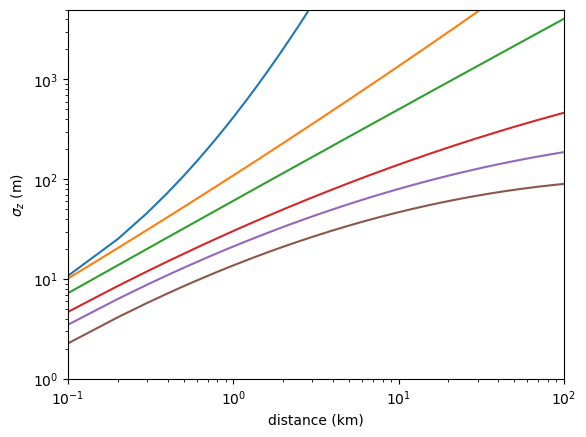

In [3]:
#check the coefficients to calculate sigma_z
x = np.arange(0.1,100,0.1)
sigma_z_A = Turner_dispersion_equation("A", x)[0]
sigma_z_B = Turner_dispersion_equation("B", x)[0]
sigma_z_C = Turner_dispersion_equation("C", x)[0]
sigma_z_D = Turner_dispersion_equation("D", x)[0]
sigma_z_E = Turner_dispersion_equation("E", x)[0]
sigma_z_F = Turner_dispersion_equation("F", x)[0]

sigma_y_A = Turner_dispersion_equation("A", x)[1]
sigma_y_B = Turner_dispersion_equation("B", x)[1]
sigma_y_C = Turner_dispersion_equation("C", x)[1]
sigma_y_D = Turner_dispersion_equation("D", x)[1]
sigma_y_E = Turner_dispersion_equation("E", x)[1]
sigma_y_F = Turner_dispersion_equation("F", x)[1]

plt.plot(x, sigma_z_A)
plt.plot(x, sigma_z_B)
plt.plot(x, sigma_z_C)
plt.plot(x, sigma_z_D)
plt.plot(x, sigma_z_E)
plt.plot(x, sigma_z_F)

plt.ylim(1, 5000)
plt.xlim(.1, 100)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("distance (km)")
plt.ylabel('$\sigma_z$ (m)')
plt.show()

In [4]:
# run example calculation of ground concentration
q = 21630000 #so2 flux in microgram per s
stability_class = "A"
ht = 131 # m
u = 2.45 # m/s
x = 600 # m
y = 0 # m on plume centerline (directly beneath plume centerline)
so2_conc = ground_conc(x,y,u,q,ht,stability_class)
print ("so2 concentration on ground 600 m downwind from source = ", so2_conc, "microgram/m3")

so2 concentration on ground 600 m downwind from source =  94.7549584095107 microgram/m3


In [5]:
# run an example using a volcanic plume source

# atmospheric conditions
surface_wind_velocity = 2 # m/s, this is usually measured 10 m above surface
surface_wind_height = 10 # m (see above)
air_temperature = 15 #C
stability_class = "A"
temperature_gradient = -0.009 # K/m
gravity = 9.8 # m/s2

# vent conditions
vent_flow_rate = 19132 # Nm3/hr Note; a Nm3 is a normal cubic meter of gas at 0 C and 1 atm
vent_diameter = 1.4 #m
vent_height = 76 # m
vent_temperature = 204 #C
so2_conc_at_vent = 1428 #ppm
so2_molecular_weight = 64 # 

#location of receptor along downwind plume from vent
x = 600 #m
y = 0 #m

# Step 1: calculate the gas flow from vent (kg-mol/s)
# note: 1 kg-mol of any gas is 22.41 Nm3 of the gas
# note 3600 s in 1 hr
gas_flow_rate = (vent_flow_rate / 22.41) * 1/3600


#Step 2: calculate so2 emission rate in kg-mol/s
so2_emission_rate = gas_flow_rate * (so2_conc_at_vent * 1e-6)

#Step 3: calculate so2 emission rate in microgram/s
# note there are 10^9 microgram per kilogram
q_so2 =  so2_emission_rate * so2_molecular_weight * 1e9

print ("so2 emission rate in microgram/s =",  q_so2)
#Step 4: calculate the vent exit velocity (m/s)
# calculate the total gas flux in Nm3/s
q_total = vent_flow_rate/3600 #seconds per hour
gas_velocity = vent_exit_velocity(q_total, vent_temperature, vent_diameter)

#Step 5: calculate the (Brigg's) atmospheric stability parameter
stability_parameter = atm_stability_parameter(gravity, air_temperature, temperature_gradient)
print (stability_parameter)

#Step 6: calculate the (Brigg's) bouyancy parameter
bouyancy_parameter = plume_bouyancy_parameter(air_temperature,
                                              vent_temperature,
                                              gravity,
                                              vent_diameter,
                                              gas_velocity)
print(bouyancy_parameter)

# Step 7: find the downwind distance to the end of the transitional rise of the gas plume

x_f = downwind_distance_to_end_rise(bouyancy_parameter)
print(x_f)

# step 8: find the wind velocity at the vent height
wind_vel_vent_ht = wind_velocity_at_ht_above_surface(stability_class,
                                                     surface_wind_velocity,
                                                     surface_wind_height,
                                                     vent_height)
print(wind_vel_vent_ht)

# step 9: find plume rise to receptor location, x (m)
plume_rise_to_x = briggs_equations(stability_class,
                                   bouyancy_parameter,
                                   x, x_f, 
                                   wind_vel_vent_ht,
                                   stability_parameter)
print(plume_rise_to_x )

# step 10: find the ht of the plume center line at x(m)
center_line_ht_at_x = plume_rise_to_x + vent_height
print(center_line_ht_at_x)

#step 11: find the wind velocity at the plume centerline ht
wind_vel_centerline_ht = wind_velocity_at_ht_above_surface(stability_class,
                                                     surface_wind_velocity,
                                                     surface_wind_height,
                                                     center_line_ht_at_x)
print(wind_vel_centerline_ht )


#step 12: find the ground concentration
concentration = ground_conc(x,y,
                            wind_vel_centerline_ht,
                            q_so2,
                            center_line_ht_at_x,
                            stability_class)
print ("SO2 gas concentration at (", x,",",y,") = ", concentration, "microgram/m3")

ppm = concentration /1000
print ("SO2 gas concentration at (", x,",",y,") = ", ppm, "ppm")

so2 emission rate in microgram/s = 21673257.771828055
0.00030625
11.47712816849792
225.21216718232373
2.44969127224795
54.535705797970714
130.5357057979707
2.585847613086255
SO2 gas concentration at ( 600 , 0 ) =  90.19675708366964 microgram/m3
SO2 gas concentration at ( 600 , 0 ) =  0.09019675708366964 ppm


In [6]:
# run an example using a volcanic plume source
# output here should be 90 microgram / m3, which matches Beychok's example
# see his page 105.
#
#Specify:
# atmospheric conditions
surface_wind_velocity = 2 # m/s, this is usually measured 10 m above surface
surface_wind_height = 10 # m (see above)
air_temperature = 15 #C
stability_class = "A"
temperature_gradient = -0.009 # K/m
gravity = 9.8 # m/s2

# vent conditions
vent_flow_rate = 19132 # Nm3/hr Note; a Nm3 is a normal cubic meter of gas at 0 C and 1 atm
vent_diameter = 1.4 #m
vent_height = 76 # m
vent_temperature = 204 #C
so2_conc_at_vent = 1428 #ppm
so2_molecular_weight = 64 # 

#location of receptor along downwind plume from vent
x = 600 #m
y = 0 #m

# Step 1: calculate the gas flow from vent (kg-mol/s)
# note: 1 kg-mol of any gas is 22.41 Nm3 of the gas
# note 3600 s in 1 hr
gas_flow_rate = (vent_flow_rate / 22.41) * 1/3600


#Step 2: calculate so2 emission rate in kg-mol/s
so2_emission_rate = gas_flow_rate * (so2_conc_at_vent * 1e-6)

#Step 3: calculate so2 emission rate in microgram/s
# note there are 10^9 microgram per kilogram
q_so2 =  so2_emission_rate * so2_molecular_weight * 1e9

print ("so2 emission rate in microgram/s =",  q_so2)
#Step 4: calculate the vent exit velocity (m/s)
# calculate the total gas flux in Nm3/s
q_total = vent_flow_rate/3600 #seconds per hour
gas_velocity = vent_exit_velocity(q_total, vent_temperature, vent_diameter)

#Step 5: calculate the (Brigg's) atmospheric stability parameter
stability_parameter = atm_stability_parameter(gravity, air_temperature, temperature_gradient)
print (stability_parameter)

#Step 6: calculate the (Brigg's) bouyancy parameter
bouyancy_parameter = plume_bouyancy_parameter(air_temperature,
                                              vent_temperature,
                                              gravity,
                                              vent_diameter,
                                              gas_velocity)
print(bouyancy_parameter)

# Step 7: find the downwind distance to the end of the transitional rise of the gas plume

x_f = downwind_distance_to_end_rise(bouyancy_parameter)
print(x_f)

# step 8: find the wind velocity at the vent height
wind_vel_vent_ht = wind_velocity_at_ht_above_surface(stability_class,
                                                     surface_wind_velocity,
                                                     surface_wind_height,
                                                     vent_height)
print(wind_vel_vent_ht)

# step 9: find plume rise to receptor location, x (m)
plume_rise_to_x = briggs_equations(stability_class,
                                   bouyancy_parameter,
                                   x, x_f, 
                                   wind_vel_vent_ht,
                                   stability_parameter)
print(plume_rise_to_x )

# step 10: find the ht of the plume center line at x(m)
center_line_ht_at_x = plume_rise_to_x + vent_height
print(center_line_ht_at_x)

#step 11: find the wind velocity at the plume centerline ht
wind_vel_centerline_ht = wind_velocity_at_ht_above_surface(stability_class,
                                                     surface_wind_velocity,
                                                     surface_wind_height,
                                                     center_line_ht_at_x)
print(wind_vel_centerline_ht )


#step 12: find the ground concentration
concentration = ground_conc(x,y,
                            wind_vel_centerline_ht,
                            q_so2,
                            center_line_ht_at_x,
                            stability_class)
print ("SO2 gas concentration at (", x,",",y,") = ", concentration, "microgram/m3")



so2 emission rate in microgram/s = 21673257.771828055
0.00030625
11.47712816849792
225.21216718232373
2.44969127224795
54.535705797970714
130.5357057979707
2.585847613086255
SO2 gas concentration at ( 600 , 0 ) =  90.19675708366964 microgram/m3


In [9]:
# run an example using a volcanic plume source

# atmospheric conditions
surface_wind_velocity = 2 # m/s, this is usually measured 10 m above surface
surface_wind_height = 10 # m (see above)
air_temperature = 15 #C
stability_class = "B"
temperature_gradient = -0.009 # K/m
gravity = 9.8 # m/s2

# vent conditions
vent_flow_rate = 1e5 # Nm3/hr Note; a Nm3 is a normal cubic meter of gas at 0 C and 1 atm
vent_diameter = 10 #m
vent_height = 10 # m
vent_temperature = 1000 #C
so2_conc_at_vent = 100000 #ppm
so2_molecular_weight = 64 # 

#location of receptor along downwind plume from vent

y = 0 #m

# Step 1: calculate the gas flow from vent (kg-mol/s)
# note: 1 kg-mol of any gas is 22.41 Nm3 of the gas
# note 3600 s in 1 hr
gas_flow_rate = (vent_flow_rate / 22.41) * 1/3600


#Step 2: calculate so2 emission rate in kg-mol/s
so2_emission_rate = gas_flow_rate * (so2_conc_at_vent * 1e-6)

#Step 3: calculate so2 emission rate in microgram/s
# note there are 10^9 microgram per kilogram
q_so2 =  so2_emission_rate * so2_molecular_weight * 1e9

#Step 4: calculate the vent exit velocity (m/s)
# calculate the total gas flux in Nm3/s
q_total = vent_flow_rate/3600 #seconds per hour
gas_velocity = vent_exit_velocity(q_total, vent_temperature, vent_diameter)

#Step 5: calculate the (Brigg's) atmospheric stability parameter
stability_parameter = atm_stability_parameter(gravity, air_temperature, temperature_gradient)


#Step 6: calculate the (Brigg's) bouyancy parameter
bouyancy_parameter = plume_bouyancy_parameter(air_temperature,
                                              vent_temperature,
                                              gravity,
                                              vent_diameter,
                                              gas_velocity)


# Step 7: find the downwind distance to the end of the transitional rise of the gas plume

x_f = downwind_distance_to_end_rise(bouyancy_parameter)



## The following depend on x
## specify range of x

# specify lists
x = []
plume_rise_to_x = []
center_line_ht_at_x = []
wind_vel_centerline_ht = []
concentration = []
concentration_ppm = []



for i in range (100, 10000, 50):
    x.append(i)
    
    # step 8: find the wind velocity at the vent height
    wind_vel_vent_ht = wind_velocity_at_ht_above_surface(stability_class,
                                                     surface_wind_velocity,
                                                     surface_wind_height,
                                                     vent_height)

    # step 9: find plume rise to receptor location, x (m)
    plume_rise = briggs_equations(stability_class,
                                   bouyancy_parameter,
                                   i, x_f, 
                                   wind_vel_vent_ht,
                                   stability_parameter)
    plume_rise_to_x.append(plume_rise)
    # step 10: find the ht of the plume center line at x(m)
    center = plume_rise + float(vent_height)
    center_line_ht_at_x.append(center)
    
    #step 11: find the wind velocity at the plume centerline ht
    wind_vel_centerline = wind_velocity_at_ht_above_surface(stability_class,
                                                     surface_wind_velocity,
                                                     surface_wind_height,
                                                     center)
    wind_vel_centerline_ht.append(wind_vel_centerline)
    
    #step 12: find the ground concentration as a function of distance, x
    # microgram/m3
    conc = (ground_conc(i,y,
                            wind_vel_centerline,
                            q_so2,
                            center,
                            stability_class))
    
    concentration.append(conc/1000)
    
    concentration_ppm.append(24.45 * conc / (1000*so2_molecular_weight))


cospec_so2_flux = q_so2/1e9 * 3600 * 24 / 1000
print (cospec_so2_flux, "tonnes per day")
#la palma - 2,882 and 53,600 tonnes/day 

#maximum reported ground conc at La Palma 
# 2600 microgram/m3 - Milford et al., 2023 Science of the Total Environment 869

print("max ground concentration ", np.max(concentration)*1000, " microgram/m3")
print(" max ground concentration ", np.max(concentration_ppm), "ppm")

685.4082998661311 tonnes per day
max ground concentration  1168.7336425745195  microgram/m3
 max ground concentration  0.4464927743897969 ppm


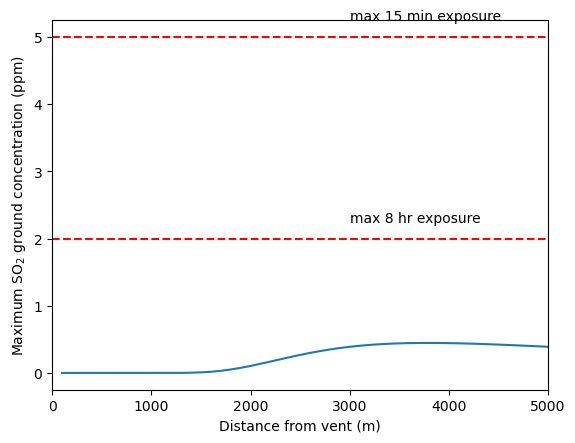

In [10]:

plt.plot(x, concentration_ppm)


plt.xlim(0,5000)
plt.plot([0,5000], [5,5], color="red", linestyle = "dashed")
plt.plot([0,5000], [2,2], color="red", linestyle = "dashed")
plt.ylabel("Maximum SO$_2$ ground concentration (ppm)")
plt.xlabel ("Distance from vent (m)")
plt.text(3000,5.25, "max 15 min exposure")
plt.text(3000,2.25, "max 8 hr exposure")
plt.savefig("./ppm_at_3_5_10m_s.png", dpi = 300)
plt.show()